# Delivery Duration Prediction


<img src='transferir.JPG' style='width:500px;height:250px'>

## DoorDash, Inc. is an American company that operates an online food ordering and food delivery platform. The company is based in San Francisco, California.

## With a 56% market share, DoorDash is the largest food delivery company in the United States. It also has a 60% market share in the convenience delivery category. As of December 31, 2020, the platform was used by 450,000 merchants, 20,000,000 consumers, and one million deliverers


## "When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience."


### Our job here is create a predictive model that gives us the right time to deliver the order, analyzing the data and choosing the variables that most impact the model. Following below the features of our dataset


### Time features

**market_id**: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

**created_at**: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)

**actual_delivery_time**: Timestamp in UTC when the order was delivered to the consumer

### Store features

**store_id**: an id representing the restaurant the order was submitted for

**store_primary_category**: cuisine category of the restaurant, e.g., italian, asian

**order_protocol**: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features

**total_items**: total number of items in the order

**subtotal**: total value of the order submitted (in cents)

**num_distinct_items**: number of distinct items included in the order

**min_item_price**: price of the item with the least cost in the order (in cents)

**max_item_price**: price of the item with the highest cost in the order (in cents)

### Market features

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

**total_onshift_dashers**: Number of available dashers who are within 10 miles of the store at the time of order creation

**total_busy_dashers**: Subset of above total_onshift_dashers who are currently working on an order

**total_outstanding_orders**: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models

We have predictions from other models for various stages of delivery process that we can use:

**estimated_order_place_duration**: Estimated time for the restaurant to receive the order from DoorDash (in seconds)

**estimated_store_to_consumer_driving_duration**: Estimated travel time between store and consumer (in seconds

In [69]:
# Import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


In [70]:
#import the dataset
df = pd.read_csv('historical_data.csv', sep = ',')

In [71]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [73]:
#checking missing values
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [74]:
# drop the missing values
df = df.dropna()
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

In [75]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))


Number of Rows: 175777
Number of Cols: 16


In [76]:
# transforming a object in a pandas datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# creating a new column call duration (order time duration)
df['duration'] = df['actual_delivery_time'] - df['created_at']
df['duration'] = df['duration'].dt.total_seconds()

# creating a new colum call hour_create (the hour that the order was created)
df['hour_created'] = df['created_at'].dt.hour
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,duration,hour_created
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,22
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,21
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,3
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,2


In [77]:
# Removing the outliers duration time
q_low = df["duration"].quantile(0.01)
q_hi  = df["duration"].quantile(0.99)

df = df[(df["duration"] < q_hi) & (df["duration"] > q_low)]

df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,duration,hour_created
count,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000,172259.000000
mean,2.747555,3558.001416,2.908481,3.208976,2703.406133,2.679483,685.184362,1161.802751,45.132690,42.052212,58.498888,307.799250,547.743746,2827.094317,8.460109
std,1.330081,2055.198738,1.512544,2.672598,1826.160529,1.624151,519.742110,560.316839,34.632513,32.230491,52.821879,89.808554,217.679068,968.904226,8.674300
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1153.000000,0.000000
25%,2.000000,1703.000000,1.000000,2.000000,1425.000000,2.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,387.000000,2118.000000,2.000000
50%,2.000000,3620.000000,3.000000,3.000000,2238.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,546.000000,2662.000000,3.000000
75%,4.000000,5341.000000,4.000000,4.000000,3423.000000,3.000000,943.000000,1395.000000,66.000000,63.000000,86.000000,446.000000,704.000000,3364.000000,19.000000
max,6.000000,6987.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,1739.000000,6476.000000,23.000000


#### An interesting thing is that 50% of all orders are between 00:00 AM and 3:00 AM

## Markets with more orders

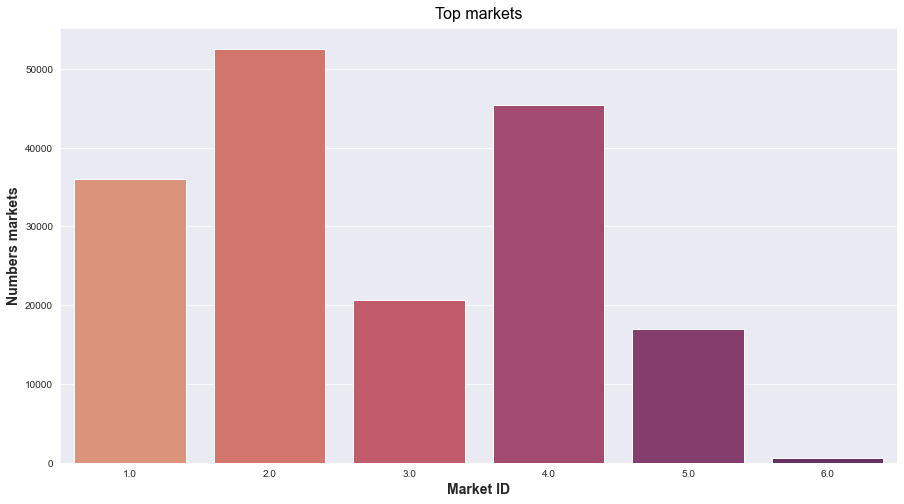

In [81]:
market_count = df['market_id'].value_counts()
market_name = market_count.index
market_val = market_count.values

font = {'weight' : 'bold',
        'size'   : 14}

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

plt.figure(figsize = (15, 8))
sns.set_style("darkgrid")
plot = sns.barplot(y=market_val,x=market_name, palette = 'flare')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('Market ID', **font)
plt.ylabel('Numbers markets', **font)
plt.title('Top markets', **title_font)
plt.show()

## Top 10 category with more orders

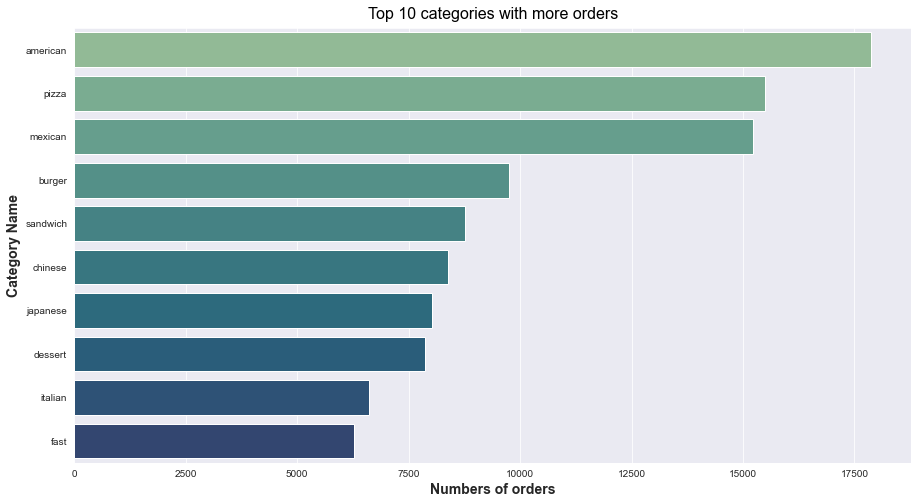

In [11]:
category_count = df['store_primary_category'].value_counts()
category_name = category_count.index[:10]
category_val = category_count.values[:10]

plt.figure(figsize = (15,8))
sns.set_style("darkgrid")
plot = sns.barplot(x=category_val, y=category_name, palette = 'crest')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('Numbers of orders', **font)
plt.ylabel('Category Name', **font)
plt.title('Top 10 categories with more orders', **title_font)
plt.show()

<ul>
<li>American is the category with most order</li>
</ul>

## Top 10 categories with the longest delivery time

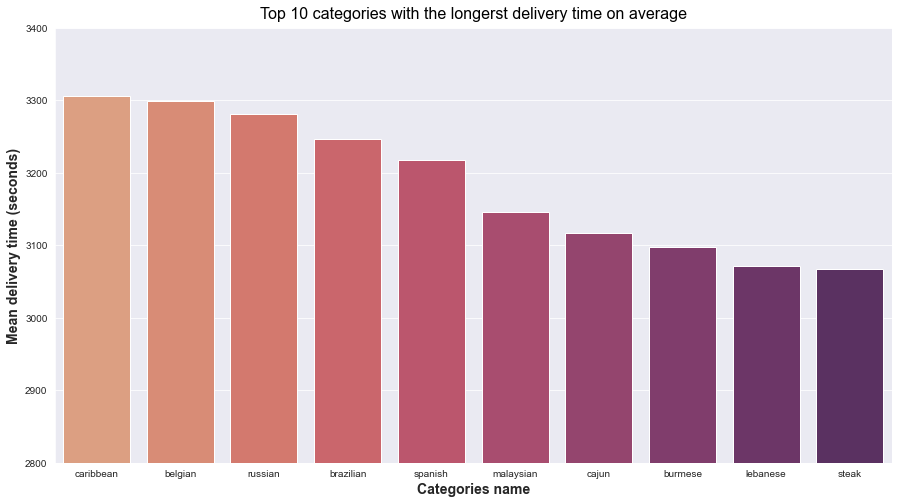

In [12]:
cat_mean_time = df[['store_primary_category','duration']].groupby('store_primary_category')['duration'].mean().sort_values(ascending=False)[:10]
mean_time_name = cat_mean_time.index
mean_time_val = cat_mean_time.values

plt.figure(figsize = (15,8))
sns.set_style("darkgrid")
plot = sns.barplot(x=mean_time_name, y=mean_time_val, palette = 'flare')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('Categories name', **font)
plt.ylabel('Mean delivery time (seconds)', **font)
plt.title('Top 10 categories with the longerst delivery time on average', **title_font)
plt.ylim(2800, 3400)
plt.show()

<ul>
<li>Caribbean is the category with longer delivery time on average</li>
</ul>

## Top 10 categories with the shortest delivery time

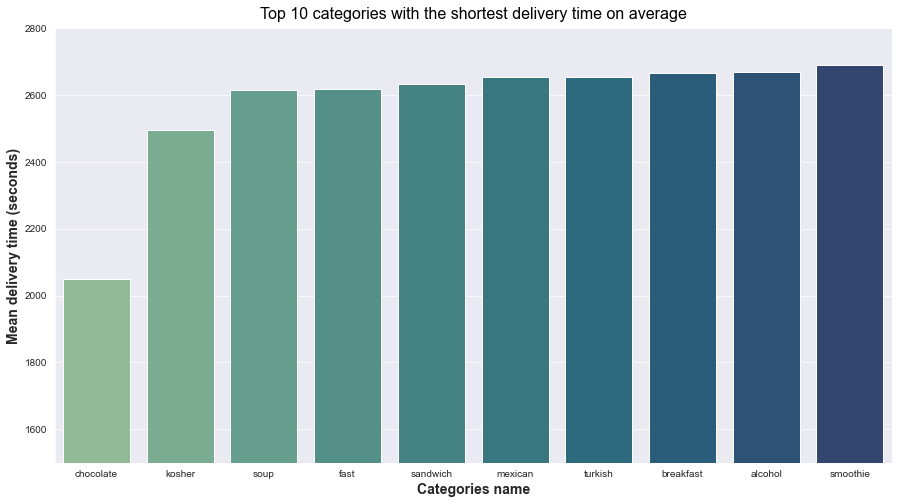

In [13]:
cat_mean_time = df[['store_primary_category','duration']].groupby('store_primary_category')['duration'].mean().sort_values(ascending=True)[:10]
mean_time_name = cat_mean_time.index
mean_time_val = cat_mean_time.values

plt.figure(figsize = (15,8))
sns.set_style("darkgrid")
plot = sns.barplot(x=mean_time_name, y=mean_time_val, palette = 'crest')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('Categories name', **font)
plt.ylabel('Mean delivery time (seconds)', **font)
plt.title('Top 10 categories with the shortest delivery time on average', **title_font)
plt.ylim(1500, 2800)
plt.show()

<ul>
<li>chocolate is the category with shortest delivery time on average</li>
</ul>

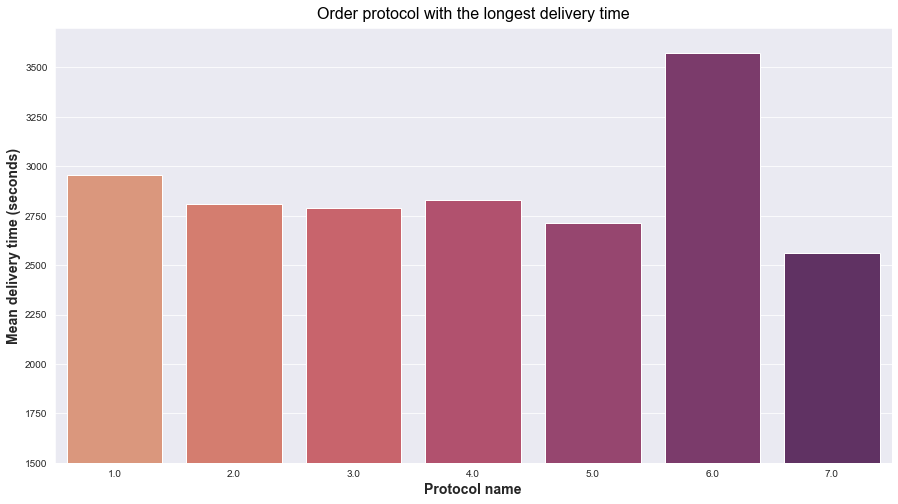

In [14]:
pro_mean_time = df[['order_protocol','duration']].groupby('order_protocol')['duration'].mean().sort_values(ascending=False)
pro_mean_time_name = pro_mean_time.index
pro_mean_time_val = pro_mean_time.values

plt.figure(figsize = (15,8))
sns.set_style("darkgrid")
plot = sns.barplot(x=pro_mean_time_name, y=pro_mean_time_val, palette = 'flare')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('Protocol name', **font)
plt.ylabel('Mean delivery time (seconds)', **font)
plt.title('Order protocol with the longest delivery time', **title_font)
plt.ylim(1500, 3700)
plt.show()

<ul>
<li>protocol order 6 is the protocol with longer delivery time on average</li>
</ul>

## Mean delivery time per hour of the day

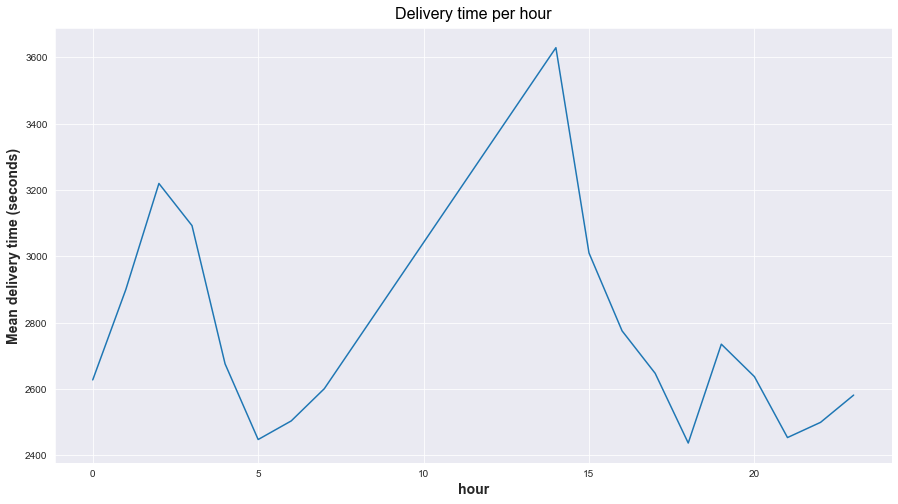

In [15]:
hour_duration = df[['hour_created','duration']].groupby('hour_created')['duration'].mean().sort_values(ascending=False)
hour_duration_name = hour_duration.index
hour_duration_val = hour_duration.values

plt.figure(figsize = (15,8))
sns.set_style("darkgrid")
plot = sns.lineplot(x=hour_duration_name, y=hour_duration_val, err_style='bars')
plot=plt.setp(plot.get_xticklabels(), rotation=0)
plt.xlabel('hour', **font)
plt.ylabel('Mean delivery time (seconds)', **font)
plt.title('Delivery time per hour', **title_font)
plt.grid(True)
plt.show()

<ul>
<li>02:00 PM is the hour that's the delivery time on average is longer</li>
</ul>

## Creating dummies variables

creating dummies varibles for **market_id**, **Order_protocol** and **store_primary_category**


In [16]:
#  market_id dummies 
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
8,0,1,0,0,0,0
14,1,0,0,0,0,0
15,1,0,0,0,0,0


In [17]:
# Order_protocol dummies
Order_protocol_dummies = pd.get_dummies(df['order_protocol'])
Order_protocol_dummies = Order_protocol_dummies.add_prefix('Order_protocol_')
Order_protocol_dummies.head()

,Order_protocol_1.0,Order_protocol_2.0,Order_protocol_3.0,Order_protocol_4.0,Order_protocol_5.0,Order_protocol_6.0,Order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
8,0,0,1,0,0,0,0
14,1,0,0,0,0,0,0
15,1,0,0,0,0,0,0


In [18]:
# store_primary_category dummies
store_primary_category_dummies = pd.get_dummies(df.store_primary_category)
store_primary_category_dummies.head()

,afghan,african,alcohol,alcohol-plus-food,american,argentine,asian,barbecue,belgian,brazilian,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Drop columns that don't impact the model

In [19]:
df = df.drop(columns =['market_id','created_at','actual_delivery_time','store_id','store_primary_category','order_protocol'],axis=1)

#drop market_id, store_primary_category, order_protocol because was created dummies variables for those features

## Concat dummies variables to the DataFrame

In [20]:
df_dummies = pd.concat([df,market_id_dummies,Order_protocol_dummies,store_primary_category_dummies], axis = 1)
df_dummies

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,0,0,0,0,0,0,0,0,0,0
8,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,...,0,0,0,0,0,0,0,0,0,0
14,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,...,0,0,0,0,0,0,0,0,0,0
15,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3,1389,3,345,649,17.0,17.0,23.0,251,331.0,...,0,0,0,0,0,0,0,0,0,0
197424,6,3010,4,405,825,12.0,11.0,14.0,251,915.0,...,0,0,0,0,0,0,0,0,0,0
197425,5,1836,3,300,399,39.0,41.0,40.0,251,795.0,...,0,0,0,0,0,0,0,0,0,0
197426,1,1175,1,535,535,7.0,7.0,12.0,446,384.0,...,0,0,0,0,0,0,0,0,0,0


## Analysis Multicollinearity between the features

Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent

Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model.

In [21]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_dummies, 10))

Top Absolute Correlations
total_onshift_dashers           total_busy_dashers          0.943852
                                total_outstanding_orders    0.936742
total_busy_dashers              total_outstanding_orders    0.933731
estimated_order_place_duration  Order_protocol_1.0          0.901108
total_items                     num_distinct_items          0.757581
subtotal                        num_distinct_items          0.680158
total_items                     subtotal                    0.554729
min_item_price                  max_item_price              0.540084
subtotal                        max_item_price              0.508450
Order_protocol_4.0              fast                        0.498634
dtype: float64


In [22]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

### Features with high correlation

In [23]:
# list with high correlation than 0.8

list_higt_corr = identify_correlated(df_dummies,0.8)
print(list_higt_corr)

['total_onshift_dashers', 'total_busy_dashers', 'estimated_order_place_duration']


In [24]:
#drop the features with high correlation
df_multicoli = df_dummies.drop(list_higt_corr, axis = 1)
df_multicoli.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_store_to_consumer_driving_duration,duration,hour_created,market_id_1.0,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,4,3441,4,557,1239,21.0,861.0,3779.0,22,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,2.0,690.0,4024.0,21,0,...,0,0,0,0,0,0,0,0,0,0
8,4,4771,3,820,1604,18.0,289.0,1586.0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,1525,1,1525,1525,8.0,795.0,2273.0,3,1,...,0,0,0,0,0,0,0,0,0,0
15,2,3620,2,1425,2195,7.0,205.0,2988.0,2,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# check the correlation again
print('top correlation between features \n')
print(get_top_abs_correlations(df_multicoli))

top correlation between features 

total_items     num_distinct_items    0.757581
subtotal        num_distinct_items    0.680158
total_items     subtotal              0.554729
min_item_price  max_item_price        0.540084
subtotal        max_item_price        0.508450
dtype: float64


## Subset the data into training and testing

In [26]:
X = df_multicoli.drop(['duration'], axis = 1)
y = df_multicoli['duration']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest Regressor

In [28]:
# Creating de model
regre = RandomForestRegressor()

In [29]:
# Training the model
regre.fit(X_train, y_train)

RandomForestRegressor()

In [30]:
importances = pd.Series(data=regre.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(5)

estimated_store_to_consumer_driving_duration    0.169297
subtotal                                        0.143760
total_outstanding_orders                        0.132300
hour_created                                    0.100157
max_item_price                                  0.091788
dtype: float64

### Amazing! the hour order is the fourth variable that most impacts the model

### Glad I created this variable!!

In [31]:
y_pred_v1 = regre.predict(X_test)

In [32]:
rmse_forest_v1 = np.round(np.sqrt(mean_squared_error(y_test, y_pred_v1)))

## Random Forest Regressor with Randomized SearchCV

In [33]:
random_forest_v2 = RandomForestRegressor()

In [34]:
# Apllying Randomized SearchCV

param_dist = {"max_depth": [1, 3, 7, None],
              "max_features": [8, 9, 10, 11],
              "min_samples_split": [8, 10, 11, 14],
              "min_samples_leaf": [1, 2, 3, 4, 5],
              "bootstrap": [True, False]}

rsearch = RandomizedSearchCV(random_forest_v2, param_distributions = param_dist, n_iter = 25, return_train_score = True)

In [35]:
rsearch.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=25,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 3, 7, None],
                                        'max_features': [8, 9, 10, 11],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [8, 10, 11, 14]},
                   return_train_score=True)

In [36]:
best_regre = rsearch.best_estimator_

y_pred_v2 = best_regre.predict(X_test)

rmse_forest_v2 = np.round(np.sqrt(mean_squared_error(y_test, y_pred_v2)))

##  Gradient Boosting Regressor

In [37]:

est = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, max_depth = 1, random_state = 0, loss = 'ls')

est.fit(X_train, y_train)

rmse_GB = np.round(np.sqrt(mean_squared_error(y_test, est.predict(X_test))))

## Linear regression

In [38]:
lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)

rmse_lin = np.round(np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test))))

In [40]:
dict = {'Random Forest': rmse_forest_v1,
        'Random Forest  SearchCV': rmse_forest_v2,
        'Gradient Boosting': rmse_GB,
        'Linear Regression': rmse_lin}

erros = pd.DataFrame(data = dict,index = ['Root Mean Squared Error'])
erros

,Random Forest,Random Forest SearchCV,Gradient Boosting,Linear Regression
Root Mean Squared Error,862.0,846.0,870.0,867.0


In [62]:
pred_values_dict = {"actual_total_delivery_duration":y_test.values.tolist(),
                   'pred_delivery_duration':y_pred_v2.tolist(),
                   'difference':abs(y_test.values - y_pred_v2).tolist()}

In [66]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df.head(10)

,actual_total_delivery_duration,pred_delivery_duration,difference
0,3834.0,3165.277777,668.722223
1,2586.0,2796.202206,210.202206
2,4398.0,2515.895692,1882.104308
3,2915.0,2774.083507,140.916493
4,5374.0,3346.988349,2027.011651
5,2484.0,2681.514872,197.514872
6,2624.0,3040.819241,416.819241
7,1663.0,2611.739226,948.739226
8,2146.0,2263.346585,117.346585
9,2058.0,2063.880478,5.880478


## conclusion

with this project we can see the categories where the dashdoor takes longer to deliver your orders, besides it was possible to determine the time of day with the longest delay in the delivery of orders and the cities (market_id) as well

we developed a predictor model using random forest and RandomizedSearchCV that gave us a Root Mean Squared Error 846